# Learning value-function in blackjack

In [17]:
using Random
using Plots
using StatsBase

In [18]:
newx = [CartesianIndex()]
deck = collect(1:13)
deck[end-2:end] .= 10
println(deck)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


* **Stick**: Player stops
* **Hit**: Request an additional card

In [19]:
"""
Draw a card from an i.i.d deck.
Values of 10 correspond to cards 10, Jack, Queen, and King.
"""
function draw_cards(n=1)
    n_vals = ones(10)
    n_vals[end] = 4
    deck_probs = ProbabilityWeights(n_vals) # Unnormalised probabilities
    cards = n == 1 ? sample(deck_probs) : sample(1:10, deck_probs, n)
    
    return cards
end


"""
Update the value of the player if she has a usable
ace at a given turn.
"""
function update_value_cards(value_cards, has_usable_ace)
    new_card = draw_cards(1)
    value_card, usable_ace = (value_cards <= 10) && (new_card == 1) ? (11, true) : (new_card, false)
    value_cards = value_cards + value_card
    has_usable_ace = has_usable_ace || usable_ace
    
    return value_cards, has_usable_ace
end


"""
Random initialisation of the player's card. At the
beginning, we draw two cards. If the sum of the cards
is less than 12, we continue hitting until we reach at
least 12.

Returns
-------
* Initial cards
* Initial value of cards
* Whether there is a usable ace
"""
function init_state()
    init_cards = draw_cards(2)
    has_usable_ace = any(1 .∈ init_cards)
    
    value_cards = sum(init_cards) + 10 * has_usable_ace
    
    while value_cards < 12
        value_cards, has_usable_ace = update_value_cards(value_cards, has_usable_ace)
    end
    
    return init_cards, value_cards, has_usable_ace 
end


"""
Create initial state of Blackjack game

Returns
-------
* array: sum of player's hand, whether player holds a usable ace, dealer's only showing card
* int: initial value of dealer's hand
"""
function init_game()
    _, player_value, player_usable_ace = init_state()
    dealer_cards, dealer_value, _ = init_state()
    dealer_card = dealer_cards[1]
    
    init_player_state = [player_value, player_usable_ace, dealer_card], dealer_value
end


"""
Return the reward when one of the players has value greater than
21
"""
function evaluate_loss(dealer_value, player_value)
    if dealer_value > 21 && player_value > 21
        reward = 0
    elseif dealer_value > 21 && player_value <= 21
        reward = 1
    elseif dealer_value <= 21 && player_value > 21
        reward = -1
    end
    return reward
end


function take_action(policy, state)
    player_val, usable_ace, dealer_card = state
    
    usable_ace = Bool(usable_ace) # Whether player hold a usable ace
    player_ix = player_val - 11 # From value card to index in policy grid
    ace_ix = usable_ace + 1 # From bool to index in policy grid

    
    # Check whether player wants another card
    if player_ix <= 10
        action = policy[player_ix, ace_ix, dealer_card]
    else
        # Player is out of bounds: losses game
        action = 0
    end
    
    return action
end


"""
Compute a single step of Blackjack

Parameters
----------
state: array(3)
    * Player's current sum
    * Whether player has usable ace
    * Dealer's one-showing card
policy array(10, 2, 10)
    Policy grid specifying whether to "hit"
    or "stick". The dimensions are specified as follows:
    1. Index of card values: 12, ..., 21
    2. Action values: hit, stick
    3. Dealer's one-showing card: 1, ..., 10
"""
function blackjack_step(state, dealer_value, policy)
    # end_of_game = false
    reward = 0
    player_val, usable_ace, dealer_card = state
    usable_ace = Bool(usable_ace) # Whether player hold a usable ace
    
    hit_player = Bool(take_action(policy, state))
        
    # ** End states **
    # It's a draw
    if player_val == dealer_value == 21
        end_of_game = true
    # Player wins with 21
    elseif player_val == 21
        reward = 1
        end_of_game = true
    # Dealer wins with 21
    elseif dealer_value == 21
        reward = -1
        end_of_game = true
    # One of the players has value above 21
    elseif dealer_value > 21 || player_val > 21
        reward = evaluate_loss(dealer_value, player_val)
        end_of_game = true
    # No player wants to hit
    elseif dealer_value >= 17 && !hit_player
        reward = dealer_value > player_val ? -1 : 1
        end_of_game = true
    # ** Continue playing **
    elseif dealer_value < 17 && !hit_player
        dealer_value = dealer_value + draw_cards()
        end_of_game = false
    elseif dealer_value >= 17 && hit_player
        player_val = player_val + draw_cards()
        end_of_game = false
    elseif dealer_value < 17 && hit_player
        dealer_value, _ = update_value_cards(dealer_value, true)
        player_val, usable_ace = update_value_cards(player_val, usable_ace)
        end_of_game = false
    end
    
    new_state = [player_val, usable_ace, dealer_card]
    return new_state, dealer_value, reward, hit_player, end_of_game
    
end


"""
Play a 1v1 game of blacjack

Returns
-------
game_hist: Array{N, 5} of N steps and
    1. player's card value
    2. player has usable ace (bool)
    3. dealer's one-showing card
    4. dealer's card value
    5. step reward
"""
function blackjack(policy)
    eog = false # end-of-game
    reward = 0
    state, dealer_value = init_game()
    game_hist = [-1; state; dealer_value; 0][newx, :]

    while !eog
        state, dealer_value, reward, action, eog = blackjack_step(state, dealer_value, policy)
        new_step = [action; state; dealer_value; reward][newx, :]
        if !eog
            game_hist = vcat(game_hist, new_step)
        end
    end
    # offsetting rewards one place back
    game_hist[:, end] = [game_hist[2:end, end]; reward]
    # offsetting actions
    final_action = take_action(policy, state)
    game_hist[:, 1] = [game_hist[2:end, 1]; final_action]
    
    return game_hist, reward
end


"""
Given an NxM-dimensional array X, evaluate whether an M-dimensional
array x is a row in X.
"""
function array_in_arrays(array, arrays)
    assertion_table = in.(array, arrays)
    assert = any(mapslices(all, assertion_table; dims=2))
    return assert
end

array_in_arrays

To model the state-action value function, we consider 11 possible states for the value of the player: the first 10 elements correspond to the values 11 to 21; the final element corresponds to values greater than 21. In this case, the reward is either `-1` if the value on the dealer's card is not greater than 21 or `0` if it is.

### Policy evaluation

In this section, we simulate many blackjack games and average the returns following each state

In [126]:
# Value player | has usable ace | dealer's showing card
policy = zeros((11, 2, 10))
policy[1:end-2, :, :] .= 1 # Sum less than 20 => hits
policy[end-2:end, :, :] .= 0; # Sum == 20 or sum == 21 => stick

In [127]:
# total sum of returns for all history
returns = zeros(size(policy))
# count of times a state was visited
counts = zeros(size(policy))

Random.seed!(314)
for _ in 1:500_000
    episode_hist, _ = blackjack(policy)
    episode_hist = reverse(episode_hist, dims=1)
    visited_states = [0 0 0]
    
    G = 0
    for row in eachrow(episode_hist)
        action, player_val, ace_val, dealer_card, _, reward = row
        G = G + reward
        
        player_ix = player_val - 11
        ace_ix = ace_val + 1
        dealer_ix = dealer_card

        state_ix = [player_ix ace_ix dealer_ix]

        # Update if state hasn't been observed and we are inside
        # a valid state
        if !array_in_arrays(state_ix, visited_states)
            player_ix = min(player_ix, 11)
            visited_states = vcat(visited_states, state_ix)
            returns[player_ix, ace_ix, dealer_ix] += G
            counts[player_ix, ace_ix, dealer_ix] += 1
        end
    end
end

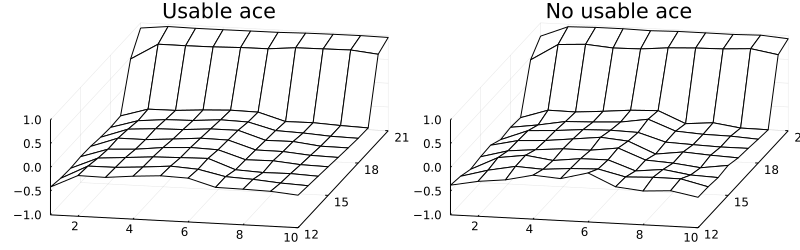

In [143]:
Vπ = (returns ./ counts)[begin:end-1, :, :]

p1 = plot(1:10, 12:21, Vπ[:, 1, :], st=:wireframe, title="Usable ace", zlim=(-1, 1), camera=(20, 60))
p2 = plot(1:10, 12:21, Vπ[:, 2, :], st=:wireframe, title="No usable ace", zlim=(-1, 1), camera=(20, 60))

plot(p1, p2, size=(800, 250))

## Episodes

The following is an example of a single episode.

In [144]:
Random.seed!(2718)
episode_hist, _ = blackjack(policy)
episode_hist

2×6 Matrix{Int64}:
 1  12  0  5  15  0
 1  14  0  5  23  1

## Monte Carlo Control
Finding an optimal policy

In [381]:
function blackjack_exploring_starts(policy)
    eog = false # end-of-game
    reward = 0
    state = [rand(12:21); rand(0:1); rand(1:10)]
    dealer_value = rand(12:21)
    
    game_hist = [-1; state; dealer_value; 0][newx, :]

    while !eog
        state, dealer_value, reward, action, eog = blackjack_step(state, dealer_value, policy)
        new_step = [action; state; dealer_value; reward][newx, :]
        if !eog
            game_hist = vcat(game_hist, new_step)
        end
    end
    # offsetting rewards one place back
    game_hist[:, end] = [game_hist[2:end, end]; reward]
    # offsetting actions
    final_action = take_action(policy, state)
    game_hist[:, 1] = [game_hist[2:end, 1]; final_action]
    
    return game_hist, reward
end



blackjack_exploring_starts (generic function with 1 method)

In [392]:
# Value player | has usable ace | dealer's showing card
policy = zeros((11, 2, 10))
policy[1:end-2, :, :] .= 1 # Sum less than 20 => hits
policy[end-2:end, :, :] .= 0 # Sum == 20 or sum == 21 => stick

state_action_size = (2, size(policy)...)

# total sum of backward-cumulative returns
returns = zeros(state_action_size)
# number of times an action-state was visited
counts = zeros(state_action_size)

Random.seed!(314)
for _ in 1:200_000
    episode_hist, _ = blackjack_exploring_starts(policy)
    episode_hist = reverse(episode_hist, dims=1)
    visited_action_states = [0 0 0 0]
    
    G = 0
    for step in eachrow(episode_hist)
        action, player_val, ace_val, dealer_card, _, reward = step
        G = G + reward

        action_ix = action + 1
        player_ix = min(player_val - 11, 11)
        ace_ix = ace_val + 1
        dealer_ix = dealer_card

        action_state_ix = [action_ix player_ix ace_ix dealer_ix]

        # Estimate value function and be greedy with respect to estimated value function
        # if state hasn't been observed and we are inside a valid state
        if !array_in_arrays(action_state_ix, visited_action_states)
            visited_action_states = vcat(visited_action_states, action_state_ix)
            
            returns[action_ix, player_ix, ace_ix, dealer_ix] += G
            counts[action_ix, player_ix, ace_ix, dealer_ix] += 1
            
            returns_state_action = returns[:, player_ix, ace_ix, dealer_ix]
            count_state_action = counts[:, player_ix, ace_ix, dealer_ix]
            Q_action = returns_state_action ./ max.(count_state_action, 1.0)
            
            new_action = argmax(Q_action) - 1 # sitck(0) or hit(1)
            policy[player_ix, ace_ix, dealer_ix] = new_action
        end
    end
end

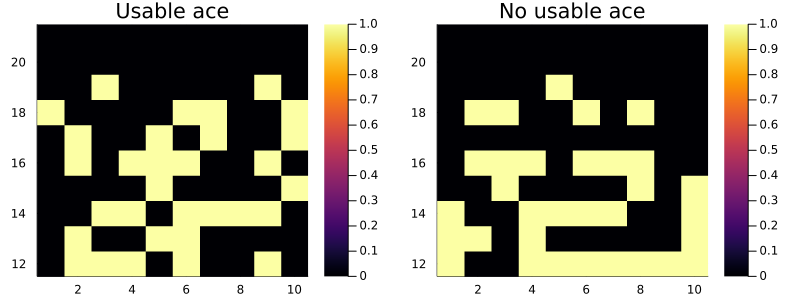

In [393]:
dealer_range = 1:10
player_range = 12:21
policy_play = policy[begin:end-1, :, :]

p1 = heatmap(dealer_range, player_range, policy_play[:, 1, :], title="Usable ace")
p2 = heatmap(dealer_range, player_range, policy_play[:, 2, :], title="No usable ace")

plot(p1, p2, size=(800, 300))

In [394]:
# total sum of returns for all history
returns = zeros(size(policy))
# count of times a state was visited
counts = zeros(size(policy))

Random.seed!(314)
for _ in 1:500_000
    episode_hist, _ = blackjack(policy)
    episode_hist = reverse(episode_hist, dims=1)
    visited_states = [0 0 0]
    
    G = 0
    for row in eachrow(episode_hist)
        _, player_val, ace_val, dealer_card, _, reward = row
        G = G + reward
        
        player_ix = min(player_val - 11, 11)
        ace_ix = ace_val + 1
        dealer_ix = dealer_card

        state_ix = [player_ix ace_ix dealer_ix]

        # Update if state hasn't been observed and we are inside
        # a valid state
        if !array_in_arrays(state_ix, visited_states)
            visited_states = vcat(visited_states, state_ix)
            returns[player_ix, ace_ix, dealer_ix] += G
            counts[player_ix, ace_ix, dealer_ix] += 1
        end
    end
end

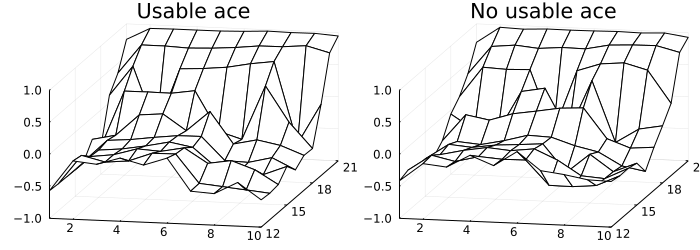

In [395]:
Vπ = (returns ./ counts)[begin:end-1, :, :]

p1 = plot(1:10, 12:21, Vπ[:, 1, :], st=:wireframe, title="Usable ace", zlim=(-1, 1), camera=(20, 45))
p2 = plot(1:10, 12:21, Vπ[:, 2, :], st=:wireframe, title="No usable ace", zlim=(-1, 1), camera=(20, 45))

plot(p1, p2, size=(700, 250))